In [63]:
# This notebook will take the housing data scraped earlier and clean/format it for further investigation.
import pandas as pd
import numpy as np
import csv
from matplotlib import pyplot as plt

pd.options.display.max_columns = None

In [64]:
priceRange = [
    [1, 250000], [250001, 300000], [300001, 350000], [350001, 400000],
    [400001, 450000], [450001, 500000], [500001, 750000], [750001, 1000000],
    [1000001, 2000000], [2000001, 5000000], [5000001, 50000000]
    ]

In [65]:
# Create function to take in column of dataframe and return modified column
# Function will take in resoFacts.associationFee and determine if its monthly, quarterly, etc and div value by appropriate amount
# Returned dataframe series will just a number representing monthly HOA fee due.

def hoaFees(series: pd.DataFrame):
    paymentFreq = series.apply(lambda x: str(x).strip("$,1234567890 "))
    payment = series.apply(lambda x: str(x).strip("$,-abcdefghijklmnopqrstuvwxyz ").replace(',', ''))
    payment = payment.apply(lambda x: float(x))

    paymentFreq.replace('', 0, inplace=True)

    for i, freq in enumerate(paymentFreq):
        if freq == 'monthly':
            payment[i] = payment[i]

        elif freq == 'quarterly':
            payment[i] = payment[i]/4

        elif freq == 'semi-annually':
            payment[i] = payment[i]/6

        elif freq == 'annually':
            payment[i] = payment[i]/12

        else:
            payment[i] = 0
    
    payment = round(payment)
    return payment

# Concat partial URL with website prefix
def fullURL(hdpURL: str):
    hdpURL = 'www.zillow.com' + str(hdpURL)
    return hdpURL

# Set area units to a consistent value of 'Square Feet'
def areaUnitConversion(units: pd.DataFrame):
    
    # Input validation
    if 'lotAreaUnits' not in units.columns or 'lotAreaValue' not in units.columns:
        raise ValueError("Input DataFrame must have 'lotAreaUnits' and 'lotAreaValue' columns.")
    
    # Create a copy of the DataFrame to avoid in-place changes
    units_copy = units.copy(deep=True)

    for idx in units_copy.index:
        if units_copy.loc[idx, 'lotAreaUnits'] == 'Acres':
            units_copy.loc[idx, 'lotAreaValue'] *= 43560
            units_copy.loc[idx, 'lotAreaUnits'] = 'Square Feet'
        elif units_copy.loc[idx, 'lotAreaUnits'] == 'sqft':
            units_copy.loc[idx, 'lotAreaUnits'] = 'Square Feet'

    # The function below does not work cleanly. It will cause a SettingWithCopyWarning error.
            
    # for idx in units.index:
    #     if units['lotAreaUnits'][idx] == 'Acres':
    #         units['lotAreaValue'][idx] = units['lotAreaValue'][idx] * 43560
    #         units['lotAreaUnits'][idx] = 'Square Feet'
    #     elif units['lotAreaUnits'][idx] == 'sqft':
    #         units['lotAreaUnits'][idx] = 'Square Feet'

    return units_copy

def timeOnZillowConversion(toz: str):
    units = toz.strip(' 1234567890')
    if units == 'day':
        units = toz
    elif units == 'days':
        units = toz
    else:
        units = '1 day'
    return units

In [66]:
for i, price in enumerate(priceRange):
    if i == 0:
        df_forSale = pd.read_csv(f'Raw_Housing_Data/housingData_{price[0]}_{price[1]}.csv',
                                 index_col=0, dtype={'zipcode':str})
        df_recentlySold = pd.read_csv(f'Raw_Housing_Data/housingData_recentlySold_{price[0]}_{price[1]}.csv',
                                      index_col=0, dtype={'zipcode':str})
    else:
        df_forSale = pd.concat([df_forSale, pd.read_csv(f'Raw_Housing_Data/housingData_{price[0]}_{price[1]}.csv',
                                                        index_col=0)], axis=0, ignore_index=True)
        df_recentlySold = pd.concat([df_recentlySold, pd.read_csv(f'Raw_Housing_Data/housingData_recentlySold_{price[0]}_{price[1]}.csv',
                                                                  index_col=0)], axis=0, ignore_index=True)

In [67]:
columnNames_forSale = list(map(lambda x: x.split(', '), df_forSale.columns))
columnNames_recentlySold = list(map(lambda x: x.split(','), df_recentlySold))

with open('Raw_Housing_Data/dataframeColumnNames_forSale.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(columnNames_forSale)

with open('Raw_Housing_Data/dataframeColumnNames_recentlySold.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(columnNames_recentlySold)

In [68]:
# Manually select column names I want to keep in my downsized data frame
columnNames_forSale = ['zpid','homeType','homeStatus','timeOnZillow.1','price','streetAddress','zipcode','yearBuilt','bedrooms','bathrooms',
                       'livingAreaValue','livingAreaUnits','lotAreaValue','lotAreaUnits','zestimate','latitude','longitude',
                       'favoriteCount','pageViewCount',
                       'newConstructionType','resoFacts.associationFee','listingSubType.isForeclosure','resoFacts.isSeniorCommunity','resoFacts.propertySubType','hdpUrl']

columnNames_recentlySold = ['zpid','homeType','homeStatus','dateSoldString','timeOnZillow.1','price','streetAddress','zipcode','yearBuilt','bathrooms','bedrooms',
                            'livingAreaValue','livingAreaUnits','lotAreaValue','lotAreaUnits','zestimate','latitude','longitude',
                            'favoriteCount','pageViewCount',
                            'newConstructionType','resoFacts.associationFee','listingSubType.isForeclosure','resoFacts.isSeniorCommunity', 'resoFacts.propertySubType','hdpUrl']

df_forSale_trunc = df_forSale.loc[:,columnNames_forSale]
df_recentlySold_trunc = df_recentlySold.loc[:,columnNames_recentlySold]
# del df_forSale, df_recentlySold

In [69]:
# Do some initial data cleanup
# Set NaN values to 0. Compute quivalent monthly HOA fees to keep data consistent.
df_forSale_trunc['resoFacts.associationFee'] = df_forSale_trunc['resoFacts.associationFee'].fillna(0)
df_recentlySold_trunc['resoFacts.associationFee'] = df_recentlySold_trunc['resoFacts.associationFee'].fillna(0)
df_forSale_trunc['resoFacts.associationFee'] = hoaFees(df_forSale_trunc['resoFacts.associationFee'])
df_recentlySold_trunc['resoFacts.associationFee'] = hoaFees(df_recentlySold_trunc['resoFacts.associationFee'])

# Set NaN values to 'False'. True is already designated by default, where applicable.
df_forSale_trunc['resoFacts.isSeniorCommunity'] = df_forSale_trunc['resoFacts.isSeniorCommunity'].fillna(False)
df_recentlySold_trunc['resoFacts.isSeniorCommunity'] = df_recentlySold_trunc['resoFacts.isSeniorCommunity'].fillna(False)

# Reformat the string representing the property subtype so it can be easily worked on.
# Removing any RV Community data as it is not a valid 'single family home' sub type for this scope.
df_forSale_trunc['resoFacts.propertySubType'] = df_forSale_trunc['resoFacts.propertySubType'].apply(lambda x: str(x).strip("['']"))
df_recentlySold_trunc['resoFacts.propertySubType'] = df_recentlySold_trunc['resoFacts.propertySubType'].apply(lambda x: str(x).strip("['']"))
df_forSale_trunc = df_forSale_trunc.loc[df_forSale_trunc['resoFacts.propertySubType']!='RV Community']
df_recentlySold_trunc = df_recentlySold_trunc.loc[df_recentlySold_trunc['resoFacts.propertySubType']!='RV Community']

# Add prefix to website
df_forSale_trunc['hdpUrl']=df_forSale_trunc['hdpUrl'].apply(fullURL)
df_recentlySold_trunc['hdpUrl']=df_recentlySold_trunc['hdpUrl'].apply(fullURL)

# Convert yearBuilt to integer and drop any rows that have yearBuilt as NaN
df_forSale_trunc.dropna(subset=['yearBuilt'], inplace=True)
df_recentlySold_trunc.dropna(subset=['yearBuilt'], inplace=True)
df_forSale_trunc['yearBuilt']=df_forSale_trunc['yearBuilt'].astype(int)
df_recentlySold_trunc['yearBuilt']=df_recentlySold_trunc['yearBuilt'].astype(int)

# Drop all labels with lotAreaValue = NaN
df_forSale_trunc.dropna(subset=['lotAreaValue'], inplace=True)
df_recentlySold_trunc.dropna(subset=['lotAreaValue'], inplace=True)

# Drop all labels with lat/long = NaN
df_forSale_trunc.dropna(subset=['latitude', 'longitude'], inplace=True)
df_recentlySold_trunc.dropna(subset=['latitude', 'longitude'], inplace=True)

# Fill all zestimate = NaN values with 0
value = {'zestimate':0}
df_forSale_trunc.fillna(value=value, inplace=True)
df_recentlySold_trunc.fillna(value=value, inplace=True)

# Drop all labels with livingAreaValue = NaN -- This is the primary feature for price prediction.
# Could try to do more searches on $/sqft but for now this will suffice.
df_forSale_trunc.dropna(subset=['livingAreaValue'], inplace=True)
df_recentlySold_trunc.dropna(subset=['livingAreaValue'], inplace=True)

# Drop all bathroom and bedroom values of NaN
df_forSale_trunc.dropna(subset=['bathrooms', 'bedrooms'], inplace=True)
df_recentlySold_trunc.dropna(subset=['bathrooms', 'bedrooms'], inplace=True)

# Fill favoriteCount and pageViewCount with 0
value = {'favoriteCount':0, 'pageViewCount':0}
df_forSale_trunc.fillna(value=value, inplace=True)
df_recentlySold_trunc.fillna(value=value, inplace=True)

# Need to set all timeOnZillow.1 values of less than one day to one day.
df_recentlySold_trunc['timeOnZillow.1'].mask(df_recentlySold_trunc['dateSoldString']=='2024-02-15', '1 day', inplace=True)
df_forSale_trunc['timeOnZillow.1'] = df_forSale_trunc['timeOnZillow.1'].apply(timeOnZillowConversion)

# Need to set newConstructionType to either True of False
df_recentlySold_trunc['newConstructionType'] = df_recentlySold_trunc['newConstructionType'].apply(lambda x: str(x))
df_recentlySold_trunc['newConstructionType'] = df_recentlySold_trunc['newConstructionType']!='nan'

# Need to keep lotAreaUnits and livingAreaUnits consistently set to Square Feet.
# Will need to create a function to deal with these.
df_forSale_trunc[['lotAreaValue','lotAreaUnits']] = areaUnitConversion(df_forSale_trunc[['lotAreaValue','lotAreaUnits']])
df_recentlySold_trunc[['lotAreaValue','lotAreaUnits']] = areaUnitConversion(df_recentlySold_trunc[['lotAreaValue','lotAreaUnits']])

# Convert dateSoldString to datetime object
df_recentlySold_trunc['dateSoldString'] = pd.to_datetime(df_recentlySold_trunc['dateSoldString'])

In [70]:
# Reset Index
df_forSale_trunc.reset_index(inplace=True)
df_forSale_trunc.drop(columns=['index'], inplace=True)

df_recentlySold_trunc.reset_index(inplace=True)
df_recentlySold_trunc.drop(columns=['index'], inplace=True)

In [71]:
df_forSale_trunc.describe(include='all')

,zpid,homeType,homeStatus,timeOnZillow.1,price,streetAddress,zipcode,yearBuilt,bedrooms,bathrooms,livingAreaValue,livingAreaUnits,lotAreaValue,lotAreaUnits,zestimate,latitude,longitude,favoriteCount,pageViewCount,newConstructionType,resoFacts.associationFee,listingSubType.isForeclosure,resoFacts.isSeniorCommunity,resoFacts.propertySubType,hdpUrl
count,2.245000e+03,2245,2245,2245,2.245000e+03,2245,2245.0,2245.000000,2245.000000,2245.000000,2245.000000,2245,2.245000e+03,2245,2.245000e+03,2245.000000,2245.000000,2245.000000,2245.000000,376,2245.000000,2245,2245,2245,2245
unique,NaN,1,1,269,NaN,2242,42.0,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,1,NaN,2,2,7,2245
top,NaN,SINGLE_FAMILY,FOR_SALE,3 days,NaN,990 Quaker St,32909.0,NaN,NaN,NaN,NaN,Square Feet,NaN,Square Feet,NaN,NaN,NaN,NaN,NaN,BUILDER_SPEC,NaN,False,False,Single Family Residence,www.zillow.com/homedetails/5650-Stamford-St-Mi...
freq,NaN,2245,2245,66,NaN,2,325.0,NaN,NaN,NaN,NaN,2245,NaN,2245,NaN,NaN,NaN,NaN,NaN,376,NaN,2230,2185,2234,1
mean,2.383089e+08,NaN,NaN,NaN,5.675352e+05,NaN,NaN,1995.680624,3.516258,2.437862,2009.595100,NaN,7.957536e+05,NaN,3.637318e+05,28.173165,-80.686566,47.288196,866.015590,NaN,34.018263,NaN,NaN,NaN,NaN
std,5.211176e+08,NaN,NaN,NaN,5.394611e+05,NaN,NaN,23.921179,0.787224,0.881222,807.331728,NaN,1.612831e+07,NaN,4.673281e+05,0.222370,0.081591,55.133603,891.594184,NaN,84.445313,NaN,NaN,NaN,NaN
min,4.336783e+07,NaN,NaN,NaN,7.500000e+04,NaN,NaN,1884.000000,0.000000,1.000000,160.000000,NaN,0.000000e+00,NaN,0.000000e+00,27.833658,-80.930824,0.000000,8.000000,NaN,0.000000,NaN,NaN,NaN,NaN
25%,4.345368e+07,NaN,NaN,NaN,3.349990e+05,NaN,NaN,1979.000000,3.000000,2.000000,1536.000000,NaN,7.840800e+03,NaN,0.000000e+00,27.989408,-80.729880,14.000000,287.000000,NaN,0.000000,NaN,NaN,NaN,NaN
50%,5.461239e+07,NaN,NaN,NaN,3.999000e+05,NaN,NaN,1999.000000,3.000000,2.000000,1865.000000,NaN,1.001880e+04,NaN,3.256000e+05,28.121946,-80.679330,32.000000,653.000000,NaN,0.000000,NaN,NaN,NaN,NaN
75%,1.041322e+08,NaN,NaN,NaN,5.999000e+05,NaN,NaN,2021.000000,4.000000,3.000000,2271.000000,NaN,1.219680e+04,NaN,4.429000e+05,28.340923,-80.638830,61.000000,1149.000000,NaN,33.000000,NaN,NaN,NaN,NaN


In [72]:
# df_recentlySold_trunc.describe(include='all')

---
Follow the **five** steps found in the **Data Detox** Towards Data Science article.
1) Check data types and nulls - DONE
2) Check for duplicate entries - DONE
3) Check for unnecessary white space
4) Check min and max values
5) Check for outliers

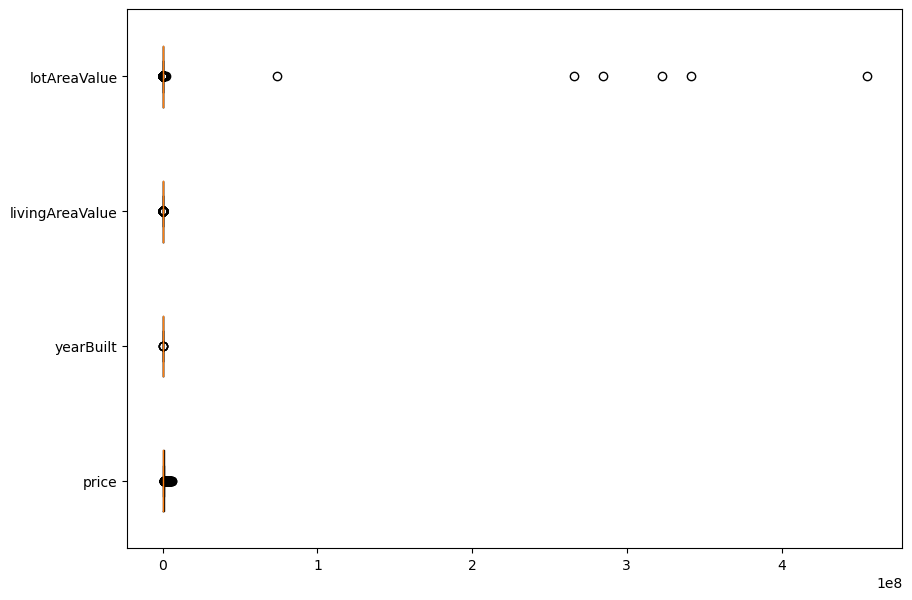

In [73]:
# Create box plot for all numeric data. Check for outliers.

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
ax.boxplot(df_forSale_trunc[['price','yearBuilt','livingAreaValue','lotAreaValue']], vert=False)
ax.set_yticklabels(['price','yearBuilt','livingAreaValue','lotAreaValue'])
plt.show()

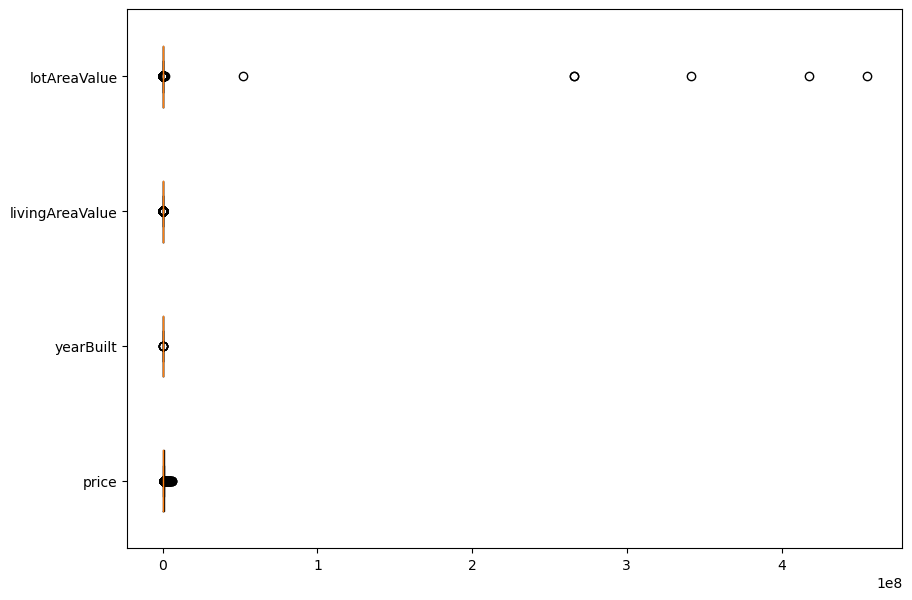

In [74]:
# Create box plot for all numeric data. Check for outliers.

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
ax.boxplot(df_recentlySold_trunc[['price','yearBuilt','livingAreaValue','lotAreaValue']], vert=False)
ax.set_yticklabels(['price','yearBuilt','livingAreaValue','lotAreaValue'])
plt.show()

In [75]:
# df_forSale_trunc.info()

In [76]:
# df_recentlySold_trunc.info()

In [77]:
# for column_ in columnNames_forSale:
#     nullValueCount = df_forSale_trunc[column_].isnull().sum()
#     print(f'Number of NaN values in {column_}: {nullValueCount}')

In [78]:
# for column_ in columnNames_recentlySold:
#     nullValueCount = df_recentlySold_trunc[column_].isnull().sum()
#     print(f'Number of NaN values in {column_}: {nullValueCount}')

In [79]:
# Check for duplicates
# print(f'There are {df_forSale_trunc.price.loc[df_forSale_trunc.duplicated()].count()} duplicates in df_forSale_trunc.')
# print(f'There are {df_recentlySold_trunc.price.loc[df_recentlySold_trunc.duplicated()].count()} duplicates in df_recentlySold_trunc.')

In [80]:
# Check for outliers
# Currently there is one house built in 1884 in df_forSale_trunc. This would count as an outlier I think. Probably need to remove.

In [81]:
# Export dataframes to csv
df_forSale_trunc.to_csv('cleaned_forSale_data.csv', sep=',', index=True, encoding='utf-8')
df_recentlySold_trunc.to_csv('cleaned_recentlySold_data.csv', sep=',', index=True, encoding='utf-8')

In [82]:
del df_forSale_trunc, df_recentlySold_trunc